# Higgs Boson Decaying to Tau Leptons

<img src="https://raw.githubusercontent.com/illinois-dap/DataAnalysisForPhysicists/main/img/Project_HiggsTauTau-EventDisplay.jpg" width=700 align=left></img><br>

## <span style="color:Orange">Overview</span>

From [[1]](https://papers.nips.cc/paper_files/paper/2014/file/e1d5be1c7f2f456670de3d53c7b54f4a-Paper.pdf), “The Higgs boson is an elementary particle in the Standard Model of particle physics, produced by the quantum excitation of the Higgs field, one of the fields in particle physics theory.It is named after physicist Peter Higgs, who in 1964, along with six other scientists, proposed the mechanism, which suggested the existence of such a particle. Its existence was confirmed by the ATLAS and CMS collaborations based on collisions in the LHC at CERN.

On December 10, 2013, two of the physicists, Peter Higgs and François Englert, were awarded the Nobel Prize in Physics for their theoretical predictions. Although Higgs's name has come to be associated with this theory, several researchers between about 1964 and 1972 independently developed different parts of it.”

The Standard Model (SM) of particle physics predicts the existence of a Higgs boson. It was discovered at CERN in 2012 by the ATLAS and CMS collaborations, with contributions to the data analysis in the discovery paper by Neubauer’s research group at Illinois.

## <span style="color:Orange">Data Sources</span>

Original Source
* https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz

File URLs
* https://courses.physics.illinois.edu/phys503/fa2023/data/projects/HiggsTauTau/HIGGS.csv.gz

## <span style="color:Orange">Questions</span>

Please refer to the corresponding Project 01 notebook for background questions related to this project. In this project, you are to focused on machine learning application(s).

### <span style="color:LightGreen">Question 01</span>

Implement and train one of the neural networks (NN) described in __[1]__. Be sure to set aside test data from the original data set which is not used in the training. You should implement a NN one that makes the training time manageable, like one of the shallow networks with hyperparameters shown in Table 1 of __[1]__ or even a smaller network. Can you show the NN classification output (analogous to Figure 4)?

In [1]:
%pip install xgboost # A boosted decision tree would potentially be a good idea for this problem. We used XGBoost in a similar project last year for B0->K*MuMu decay

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
import os.path
import subprocess
import autograd.numpy as anp
import autograd
import warnings
warnings.filterwarnings('ignore')


# import matplotlib.collections
# import scipy.signal
# from sklearn import model_selection
# import xgboost

# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()
# print(tf.__version__)


# Use CPU rather than GPU for keras neural networks
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""
from tensorflow import keras
from tqdm.keras import TqdmCallback

In [2]:
def wget_data(url: str):
    local_path = './tmp_data'
    p = subprocess.Popen(["wget", "-nc", "-P", local_path, url], stderr=subprocess.PIPE, encoding='UTF-8')
    rc = None
    while rc is None:
      line = p.stderr.readline().strip('\n')
      # if len(line) > 0:
      #   print(line)
      rc = p.poll()

def locate_data(name, check_exists=True):
    local_path='./tmp_data'
    path = os.path.join(local_path, name)
    if check_exists and not os.path.exists(path):
        raise RuntimeError('No such data file: {}'.format(path))
    return path

In [3]:
wget_data('https://courses.physics.illinois.edu/phys503/fa2023/data/projects/HiggsTauTau/HIGGS.csv.gz')

In [4]:
data = pd.read_csv(locate_data('HIGGS.csv.gz'), names = ['signal', 'lepton  pT', 'lepton  eta', 'lepton  phi', 'missing energy magnitude', 'missing energy phi', 'jet 1 pt', 'jet 1 eta', 'jet 1 phi', 'jet 1 b-tag', 'jet 2 pt', 'jet 2 eta', 'jet 2 phi', 'jet 2 b-tag', 'jet 3 pt', 'jet 3 eta', 'jet 3 phi', 'jet 3 b-tag', 'jet 4 pt', 'jet 4 eta',
                'jet 4 phi', 'jet 4 b-tag', 'm_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb'], header = None)

In [14]:
# Set the random seed to make sure we get reproducible results (we get the same every time we run)
keras.utils.set_random_seed(0)
cutoff = 1000000 #5500000 is half of the dataset. Perhaps 70% would be more ideal
training_data = np.array(data[['lepton  pT', 'lepton  eta', 'lepton  phi', 'missing energy magnitude', 'missing energy phi', 'jet 1 pt', 'jet 1 eta', 'jet 1 phi', 'jet 1 b-tag', 'jet 2 pt', 'jet 2 eta', 'jet 2 phi', 'jet 2 b-tag', 'jet 3 pt', 'jet 3 eta', 'jet 3 phi', 'jet 3 b-tag', 'jet 4 pt', 'jet 4 eta',
                'jet 4 phi', 'jet 4 b-tag', 'm_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb']].iloc[0:cutoff]).reshape(cutoff,1,28)
training_output = np.array(data["signal"].iloc[0:cutoff])

In [7]:
# Make model
# The smallest model in the paper is 3 layers of 100 units
# Perhaps another method to speed up would be to only look at high level features

x = keras.layers.Input(shape=(1,28))
y = keras.layers.SimpleRNN(100,activation="tanh", return_sequences=True)(x)
y = keras.layers.SimpleRNN(100,activation="tanh", return_sequences=True)(y)
y = keras.layers.SimpleRNN(1,activation="linear", return_sequences=False)(y)
model  = keras.Model(inputs=x,outputs=y)

In [9]:
# This is a new even smaller model
x = keras.layers.Input(shape=(1,28))
y = keras.layers.SimpleRNN(20,activation="tanh", return_sequences=True)(x)
y = keras.layers.SimpleRNN(20,activation="tanh", return_sequences=True)(y)
y = keras.layers.SimpleRNN(1,activation="linear", return_sequences=False)(y)
model  = keras.Model(inputs=x,outputs=y)

In [ ]:
# Train model
model.compile(
    optimizer = keras.optimizers.Adam(),
    loss = keras.losses.MeanSquaredError()
)
# Batch size and epoch parameters from the paper
history = model.fit(
    training_data,
    training_output,
    batch_size=100,        # The training takes groups of samples (in this case 100 samples at a time)
    epochs=50,             # The number of times to iterate through our dataset
    validation_split = 0,  # Use 0% of data to check accuracy
    verbose=0,             # Don't print info as it trains
    callbacks=[TqdmCallback(verbose=0)]
)

0epoch [00:00, ?epoch/s]

In [62]:
results = model(np.array(data[['lepton  pT', 'lepton  eta', 'lepton  phi', 'missing energy magnitude', 'missing energy phi', 'jet 1 pt', 'jet 1 eta', 'jet 1 phi', 'jet 1 b-tag', 'jet 2 pt', 'jet 2 eta', 'jet 2 phi', 'jet 2 b-tag', 'jet 3 pt', 'jet 3 eta', 'jet 3 phi', 'jet 3 b-tag', 'jet 4 pt', 'jet 4 eta',
                'jet 4 phi', 'jet 4 b-tag', 'm_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb']].iloc[cutoff:]).reshape(11000000-cutoff,1,28)).numpy()

In [35]:
true_results = np.array(data["signal"].iloc[cutoff:])

In [73]:
signal = np.array([])
background = np.array([])
for i in range(0,11000000-cutoff):
  if true_results[i] == 1:
    signal = np.append(signal, results[i])
  else:
    background = np.append(background, results[i])

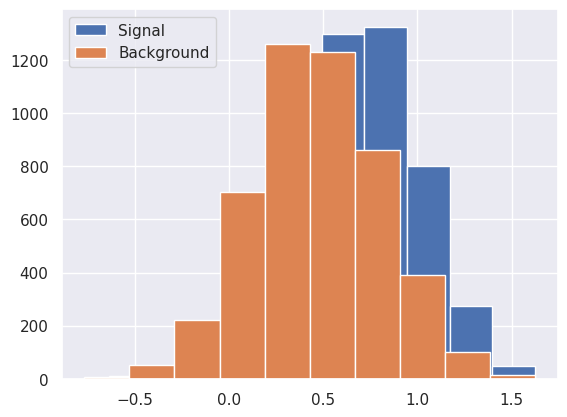

In [76]:
plt.hist(signal, label = "Signal")
plt.hist(background, label = "Background")
plt.legend()
plt.show()

I have been having trouble getting this to work with the full dataset as collab keeps running out of ram and it takes a long time. Here is a preliminary test trained on 10000 samples and tested with a further 10000 samples, which is far from ideal.

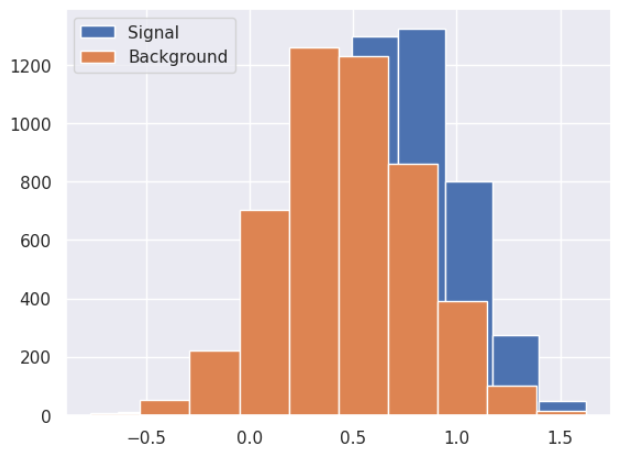

---

## <span style="color:Orange">References</span>

__[<span style="color:Red">1</span>]__ P.J. Sadowski, D. Whiteson, P. Baldi, "Searching for Higgs Boson Decay Modes with Deep Learning", _Advances in Neural Information Processing Systems 27 (NIPS 2014)_ (https://papers.nips.cc/paper/2014/hash/e1d5be1c7f2f456670de3d53c7b54f4a-Abstract.html)


---

## <span style="color:Orange">Acknowledgements</span>

* Initial version: Mark Neubauer

© Copyright 2023